In [ ]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.6 MB/s eta 0:00:00


In [ ]:
#imports
import sqlite3
import numpy as np
import pandas as pd

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#split
from sklearn.model_selection import train_test_split

#model
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

In [ ]:
%load_ext sql

In [ ]:
%sql sqlite:///../content/drive/MyDrive/nepal.sqlite
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

In [ ]:
%%sql

select * from household_demographics limit 5;

 * sqlite:///../content/drive/MyDrive/nepal.sqlite
Done.


household_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household
101,Male,31.0,Rai,Illiterate,Rs. 10 thousand,3.0,0.0
201,Female,62.0,Rai,Illiterate,Rs. 10 thousand,6.0,0.0
301,Male,51.0,Gharti/Bhujel,Illiterate,Rs. 10 thousand,13.0,0.0
401,Male,48.0,Gharti/Bhujel,Illiterate,Rs. 10 thousand,5.0,0.0
501,Male,70.0,Gharti/Bhujel,Illiterate,Rs. 10 thousand,8.0,0.0


In [ ]:
%%sql
select * from id_map limit 1;

 * sqlite:///../content/drive/MyDrive/nepal.sqlite
Done.


household_id,building_id,vdcmun_id,district_id
5601,56,7,1


In [ ]:
#creating the query
%%sql

SELECT h.*, s.*, i.vdcmun_id, d.damage_grade
FROM household_demographics AS h
JOIN id_map AS i ON i.household_id = h.household_id
JOIN building_structure as s on i.building_id = s.building_id
JOIN building_damage as d on i.building_id = d.building_id

where district_id = 4
limit 5

 * sqlite:///../content/drive/MyDrive/nepal.sqlite
Done.


household_id,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,building_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,superstructure,vdcmun_id,damage_grade
16400201,Female,46.0,Chhetree,Class 5,Rs. 10-20 thousand,4.0,1.0,164002,3,3,20,560,18,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Repaired and used,"Stone, mud mortar",38,Grade 2
16408101,Male,66.0,Chhetree,Illiterate,Rs. 10 thousand,5.0,0.0,164081,2,2,21,200,12,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",38,Grade 2
16408901,Male,54.0,Magar,Class 4,Rs. 10 thousand,5.0,1.0,164089,3,3,18,315,20,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",38,Grade 2
16409801,Male,36.0,Chhetree,Class 5,Rs. 10 thousand,6.0,1.0,164098,2,2,45,290,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",38,Grade 3
16410301,Female,39.0,Chhetree,Class 4,Rs. 10 thousand,3.0,0.0,164103,2,2,21,230,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",38,Grade 3


In [ ]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query

    query = """
    SELECT h.*, s.*, i.vdcmun_id, d.damage_grade
    FROM household_demographics AS h
    JOIN id_map AS i ON i.household_id = h.household_id
    JOIN building_structure as s on i.building_id = s.building_id
    JOIN building_damage as d on i.building_id = d.building_id

    where district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query,conn, index_col = "household_id")

    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Add high-cardinality / redundant column
    drop_cols.append("building_id")

    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Drop old target
    drop_cols.append("damage_grade")

    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")

    # Group caste column
    # we will take the top 10 castes and then we will club the rest
    top_10 = df["caste_household"].value_counts().head(10).index

    #using a lambda function to club everything else under "other"
    df["caste_household"] = df["caste_household"].apply(lambda c: c if c in top_10 else "other")

    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    return df

In [ ]:
df = wrangle("../content/drive/MyDrive/nepal.sqlite")
df.head()

,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,vdcmun_id,severe_damage
household_id,,,,,,,,,,,,,,,,,,,,
16400201,Female,46.0,Chhetree,Class 5,Rs. 10-20 thousand,4.0,1.0,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16408101,Male,66.0,Chhetree,Illiterate,Rs. 10 thousand,5.0,0.0,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16408901,Male,54.0,Magar,Class 4,Rs. 10 thousand,5.0,1.0,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16409801,Male,36.0,Chhetree,Class 5,Rs. 10 thousand,6.0,1.0,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16410301,Female,39.0,Chhetree,Class 4,Rs. 10 thousand,3.0,0.0,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0


In [ ]:
#since we added a lot of new features - looking at high and low card features
df.select_dtypes("object").nunique()
# we can look at the caste_household colum that has 63 unique values

,0
gender_household_head,2
caste_household,11
education_level_household_head,19
income_level_household,5
land_surface_condition,3
foundation_type,5
roof_type,3
ground_floor_type,5
other_floor_type,4
position,4


In [ ]:
#grouping categorical features to reduce cardinality
df["caste_household"].value_counts().head(10)

,count
caste_household,
Gurung,15119
Brahman-Hill,13043
Chhetree,8766
Magar,8180
Sarki,6052
Newar,5906
Kami,3565
Tamang,2396
Kumal,2271


In [ ]:
df["caste_household"].value_counts().tail(10)
# we can see that for a lot of the castes the number of observations = 1
# we can group them together as "other" category

,count
caste_household,
Kanu,2
Thami,2
Hajam/Thakur,2
Byasi/Sauka,1
Satar/Santhal,1
Kayastha,1
Kalar,1
Dhimal,1
Kalwar,1


In [ ]:
# we will take the top 10 castes and then we will club the rest
#top_10 = df["caste_household"].value_counts().head(10).index

#using a lambda function to club everything else under "other"
#df["caste_household"].apply(lambda c: c if c in top_10 else "other").value_counts()

,count
caste_household,
Gurung,15119
Brahman-Hill,13043
Chhetree,8766
other,8608
Magar,8180
Sarki,6052
Newar,5906
Kami,3565
Tamang,2396


In [ ]:
target = "severe_damage"
X = df.drop(["severe_damage","vdcmun_id"], axis = 1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size = 0.2,
    random_state = 42)

In [ ]:
#baseline accuracy
acc_baseline = y_train.value_counts(normalize = True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.63


In [ ]:
from category_encoders import OneHotEncoder
model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    LogisticRegression(max_iter = 7000)
)
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['gender_household_head', 'caste_household',
                                     'education_level_household_head',
                                     'income_level_household',
                                     'land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=7000))])

In [ ]:
acc_train = accuracy_score(y_train,model.predict(X_train))
acc_test = model.score(X_test,y_test)

print("LR Training Accuracy:", round(acc_train,2))
print("LR Validation Accuracy:", round(acc_test,2))

LR Training Accuracy: 0.72
LR Validation Accuracy: 0.72


In [ ]:
features = model.named_steps["onehotencoder"].get_feature_names()
importances = model.named_steps["logisticregression"].coef_[0]
feat_imp = pd.Series(np.exp(importances), index = features).sort_values()
feat_imp.head()

/tmp/ipython-input-128231561.py:1: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  features = model.named_steps["onehotencoder"].get_feature_names()


,0
superstructure_Other,0.234651
"superstructure_RC, engineered",0.348623
foundation_type_RC,0.370733
"superstructure_Brick, cement mortar",0.419383
roof_type_RCC/RB/RBC,0.424224


<Axes: >

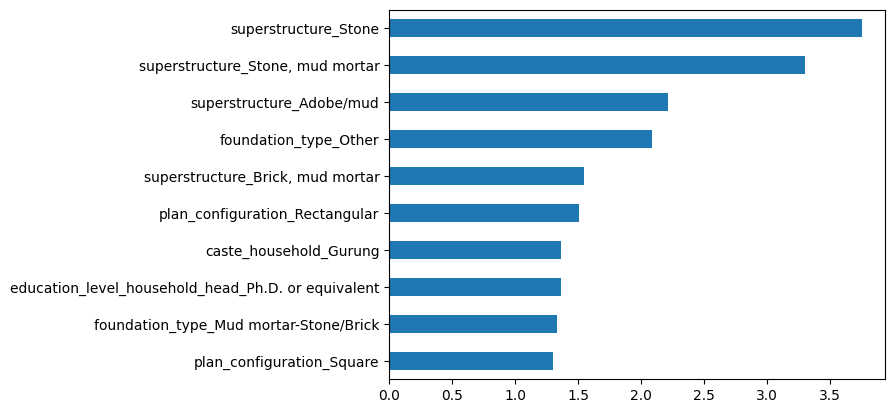

In [ ]:
feat_imp.tail(10).plot(kind = "barh")

<Axes: >

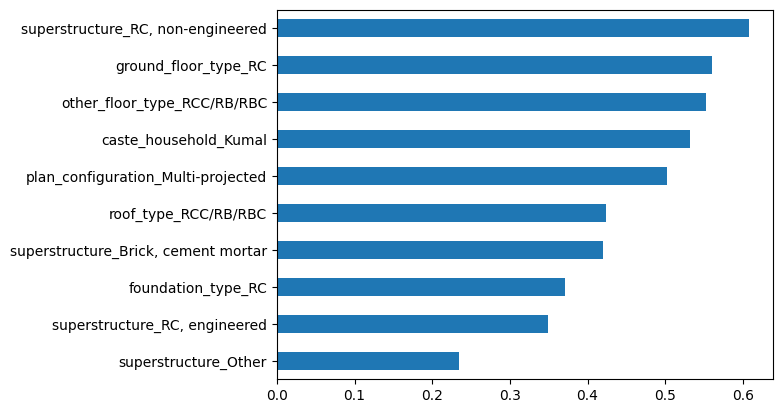

In [ ]:
feat_imp.head(10).plot(kind = "barh")